In [1]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


                           min cpu       max cpu       avg cpu
timestamp                                                     
2017-01-01 00:00:00  715146.536821  2.223302e+06  1.229569e+06
2017-01-01 00:05:00  700473.840324  2.212393e+06  1.211322e+06
2017-01-01 00:10:00  705953.565850  2.213057e+06  1.206635e+06
2017-01-01 00:15:00  688383.073221  2.187572e+06  1.190369e+06
2017-01-01 00:20:00  688276.551033  2.183684e+06  1.180992e+06


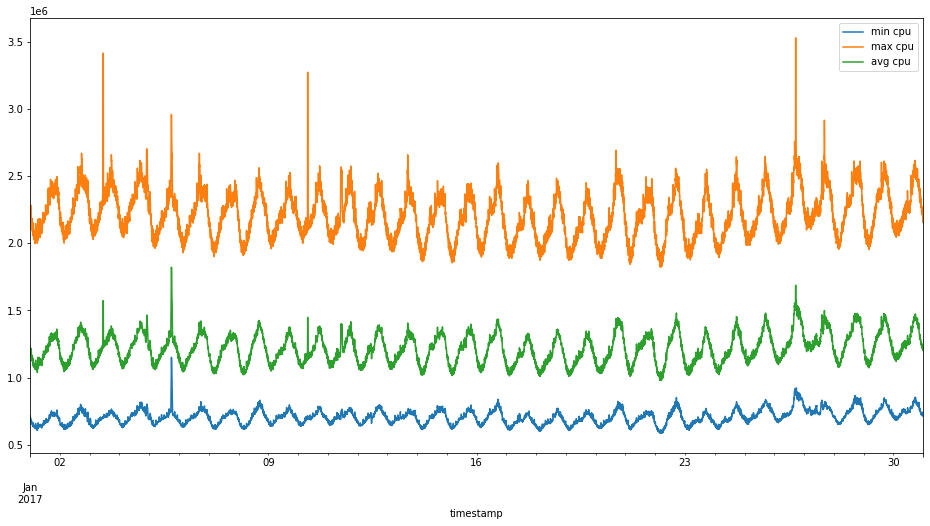

In [2]:
# let's load the dataset

df = pd.read_csv("./azure.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y.%m.%d %H:%M:%S')
df = df.set_index('timestamp')
print(df.head())
df.plot(figsize=(16,8))
plt.show()

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
min cpu,8640.0,7.075603e+05,53720.511880,5.862266e+05,6.675541e+05,7.050560e+05,7.411543e+05,1.151024e+06
max cpu,8640.0,2.205312e+06,172360.725309,1.823027e+06,2.072256e+06,2.196693e+06,2.330497e+06,3.529283e+06
avg cpu,8640.0,1.215661e+06,109615.403237,9.786379e+05,1.125854e+06,1.210631e+06,1.298056e+06,1.821756e+06


In [5]:
df

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06
...,...,...,...
2017-01-30 23:35:00,728008.315162,2.233166e+06,1.242129e+06
2017-01-30 23:40:00,737452.951022,2.219408e+06,1.235937e+06
2017-01-30 23:45:00,742153.686192,2.188120e+06,1.224276e+06


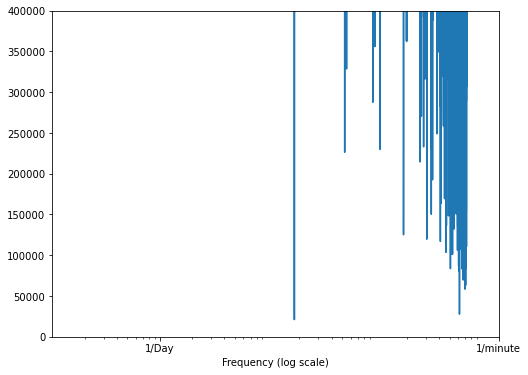

In [6]:
# which frequencies are important in our data??
# A fast Fourier transform (FFT) is an algorithm that computes the 
# discrete Fourier transform (DFT) of a sequence, or its inverse (IDFT). 
# Fourier analysis converts a signal from its original domain (often time or space) 
# to a representation in the frequency domain and vice versa


fft = tf.signal.rfft(df['max cpu'])
f_per_dataset = np.arange(0, len(fft))

n_samples_m = len(df['max cpu'])
minutes_per_day = 24*60
days_per_dataset = n_samples_m/(minutes_per_day)

f_per_day = f_per_dataset/days_per_dataset
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 1440], labels=['1/Day', '1/minute'])
_ = plt.xlabel('Frequency (log scale)')

In [7]:
f_per_dataset

array([   0,    1,    2, ..., 4318, 4319, 4320])

In [8]:
len(f_per_day)

4321

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

In [12]:
df_std

,Column,Normalized
0,min cpu,0.363238
1,min cpu,0.052421
2,min cpu,0.168500
3,min cpu,-0.203703
4,min cpu,-0.205959
...,...,...
25915,avg cpu,0.394411
25916,avg cpu,0.333563
25917,avg cpu,0.218981
25918,avg cpu,-0.004488


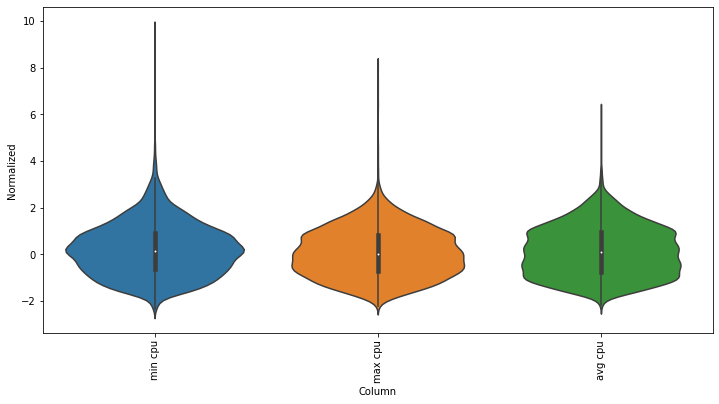

In [13]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [14]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
 
    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col='avg cpu', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')


In [15]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): None

In [16]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])
example_inputs, example_labels = w2.split_window(example_window)

In [17]:
print(example_window.shape)
print(example_inputs.shape)
print(example_labels.shape)

(3, 7, 3)
(3, 6, 3)
(3, 1, 3)


In [18]:
print(example_window)
print(example_inputs)
print(example_labels)

tf.Tensor(
[[[ 0.36323799  0.17639132  0.27099719]
  [ 0.05242057  0.11051063  0.09169865]
  [ 0.16849972  0.11451751  0.04564697]
  [-0.20370284 -0.03938366 -0.11418408]
  [-0.20595934 -0.06286184 -0.20631917]
  [-0.14637921  0.54464491  0.17980935]
  [-0.30005136  0.0363707  -0.09316289]]

 [[-1.0082824  -0.58947544 -0.82872677]
  [-1.14735454 -0.07770934 -0.6122555 ]
  [-0.99452695 -0.36709988 -0.70025738]
  [-1.20816619 -0.53527801 -0.87980771]
  [-1.42313054 -0.43158887 -0.93184039]
  [-1.37980856 -0.54706592 -0.95584832]
  [-1.37704964 -0.74897611 -1.0453    ]]

 [[ 0.87180976  1.32288186  1.09438065]
  [ 0.72293556  1.2059871   0.9943702 ]
  [ 0.55243383  1.07665365  0.86252242]
  [ 0.46739814  1.39219796  0.98448289]
  [ 0.64247051  1.31933132  1.03203207]
  [ 0.93319897  1.21715386  1.14057056]
  [ 1.16247931  1.40419321  1.28719414]]], shape=(3, 7, 3), dtype=float64)
tf.Tensor(
[[[ 0.36323799  0.17639132  0.27099719]
  [ 0.05242057  0.11051063  0.09169865]
  [ 0.16849972  0.1

In [19]:
# Single Step Models

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["avg cpu"]
)

In [20]:
for example_inputs, example_labels in single_step_window.train.take(1): 
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [21]:
# the first task is to predict temperature one hour into the future give, the current value of
# all features. The current values include the current temperature

# let's start with a model that predicts the temperature with no change, just copies the present

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [142]:
baseline = Baseline(label_index=column_indices["avg cpu"])
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

27/27 [==============================] - 0s 4ms/step - loss: 0.0263 - mean_absolute_error: 0.1260


In [161]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['avg cpu'])

In [162]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['avg cpu']

In [163]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['avg cpu']

In [164]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


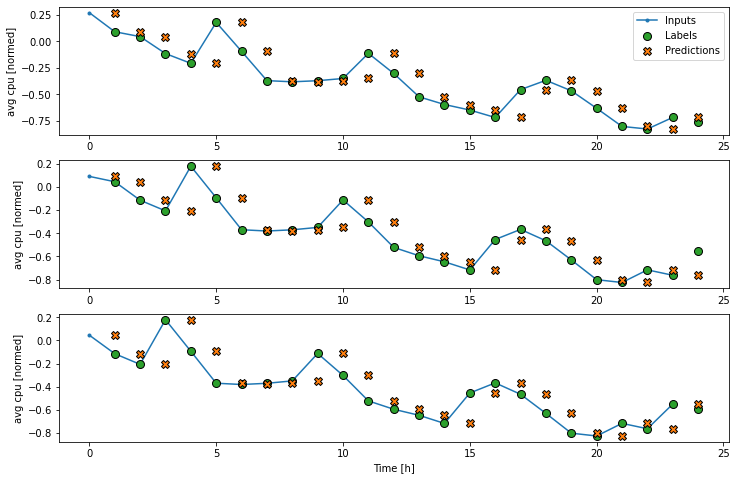

In [165]:
wide_window.plot(baseline)

In [175]:
# let's try it now with the simplest of the models : a linear one

linear = tf.keras.Sequential([tf.keras.layers.Dense(units = 1)])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 3)
Output shape: (32, 1, 1)


In [170]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [171]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose = 0)

Epoch 1/20
189/189 [==============================] - 1s 4ms/step - loss: 3.2459 - mean_absolute_error: 1.4793 - val_loss: 5.2902 - val_mean_absolute_error: 1.8328
Epoch 2/20
189/189 [==============================] - 0s 1ms/step - loss: 2.2949 - mean_absolute_error: 1.2341 - val_loss: 3.7864 - val_mean_absolute_error: 1.5453
Epoch 3/20
189/189 [==============================] - 0s 1ms/step - loss: 1.5904 - mean_absolute_error: 1.0160 - val_loss: 2.6740 - val_mean_absolute_error: 1.2940
Epoch 4/20
189/189 [==============================] - 0s 1ms/step - loss: 1.0935 - mean_absolute_error: 0.8295 - val_loss: 1.8797 - val_mean_absolute_error: 1.0820
Epoch 5/20
189/189 [==============================] - 0s 1ms/step - loss: 0.7585 - mean_absolute_error: 0.6782 - val_loss: 1.3313 - val_mean_absolute_error: 0.9093
Epoch 6/20
189/189 [==============================] - 0s 1ms/step - loss: 0.5430 - mean_absolute_error: 0.5608 - val_loss: 0.9649 - val_mean_absolute_error: 0.7727
Epoch 7/20
189/1

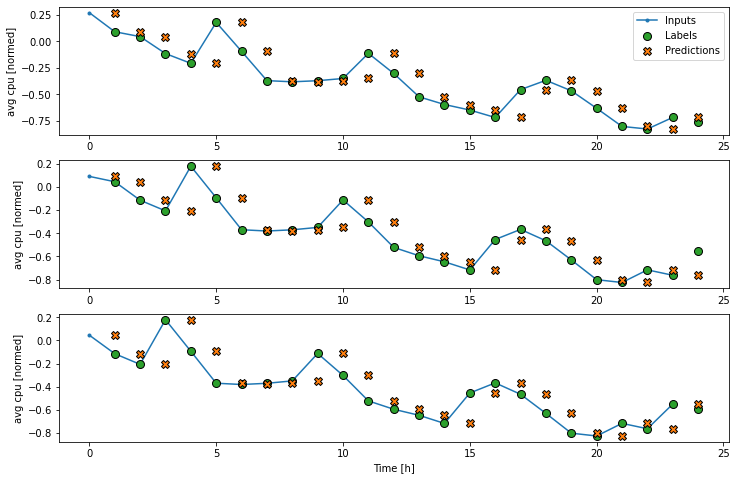

In [173]:
wide_window.plot(baseline)

In [178]:
# let's lookup dense layers now
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
189/189 [==============================] - 1s 4ms/step - loss: 0.1160 - mean_absolute_error: 0.2118 - val_loss: 0.0408 - val_mean_absolute_error: 0.1565
Epoch 2/20
189/189 [==============================] - 0s 1ms/step - loss: 0.0370 - mean_absolute_error: 0.1392 - val_loss: 0.0379 - val_mean_absolute_error: 0.1463
Epoch 3/20
189/189 [==============================] - 0s 1ms/step - loss: 0.0332 - mean_absolute_error: 0.1323 - val_loss: 0.0410 - val_mean_absolute_error: 0.1586
Epoch 4/20
54/54 [==============================] - 0s 623us/step - loss: 0.0418 - mean_absolute_error: 0.1537


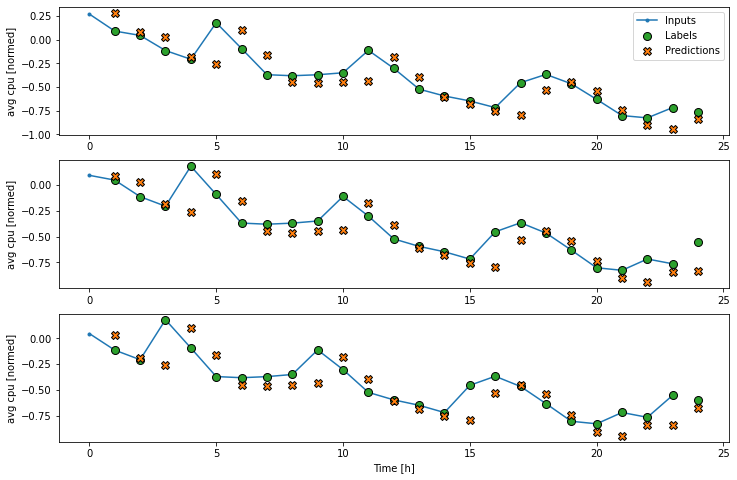

In [179]:
wide_window.plot(dense)

In [185]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['avg cpu'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['avg cpu']

In [205]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [187]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 3)
Output shape: (32, 1, 1)


In [189]:
plot_model(multi_step_dense, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [190]:
multi_step_dense.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (32, 9)                   0         
                                                                 
 dense_11 (Dense)            (32, 32)                  320       
                                                                 
 dense_12 (Dense)            (32, 32)                  1056      
                                                                 
 dense_13 (Dense)            (32, 1)                   33        
                                                                 
 reshape_1 (Reshape)         (32, 1, 1)                0         
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [191]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

54/54 [==============================] - 0s 604us/step - loss: 0.0332 - mean_absolute_error: 0.1413


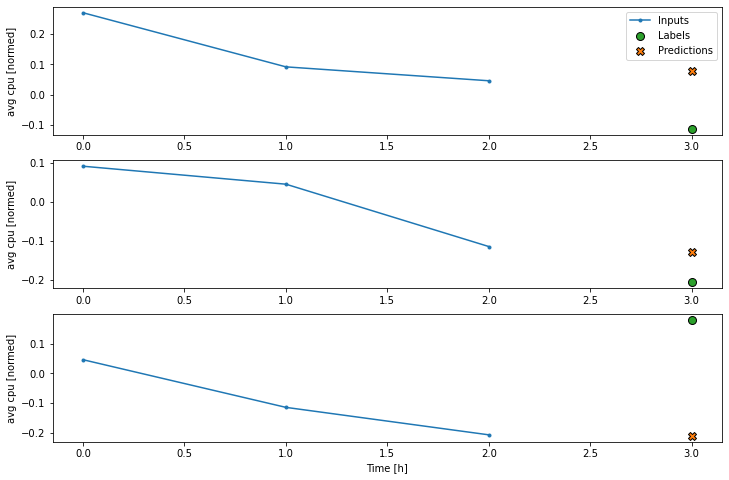

In [194]:
conv_window.plot(multi_step_dense)

In [195]:
# we have a slight prroblem, we can't give here more than one input, so not 24 like we used to do
# with the wide window before
# that's why on s'interesse au convoloutional layer to do that

# it doesn't work cause the shape of the model is set once u built it
# on a batch of data, thats why you could only make it work for one point
# and not for many points one after the other

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [196]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 3)
Output shape: (32, 1, 1)


In [200]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

54/54 [==============================] - 0s 1ms/step - loss: 0.0328 - mean_absolute_error: 0.1401


In [203]:
# the difference between this conv_model and the mutli_step_dense model
# is that the conv_model can be run on inputs of any length

"""
Note that the output is shorter than the input. 
To make training or plotting work, you need the labels, 
and prediction to have the same length. 
So build a WindowGenerator to produce wide windows with a few 
extra input time steps so the label and prediction 
lengths match:

"""

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['avg cpu'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['avg cpu']

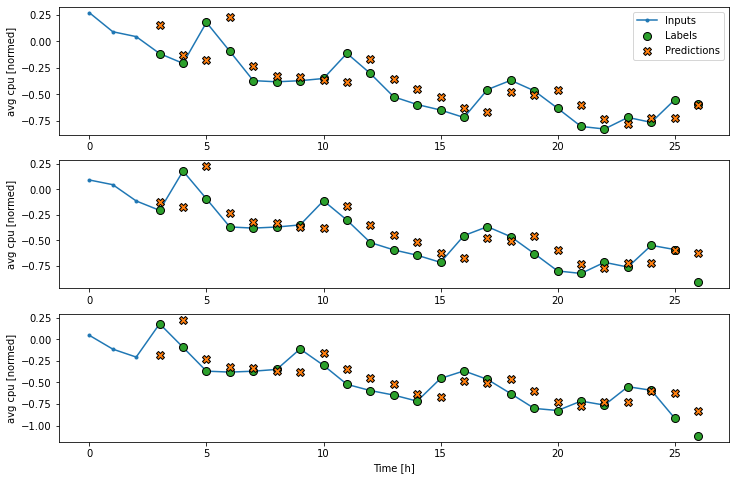

In [204]:
wide_conv_window.plot(conv_model)

# Recurrent neural network

In [211]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [212]:
# return sequences set to True or False makes the diff
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


In [213]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

 1/54 [..............................] - ETA: 3s - loss: 0.0190 - mean_absolute_error: 0.1132

54/54 [==============================] - 0s 3ms/step - loss: 0.0313 - mean_absolute_error: 0.1353


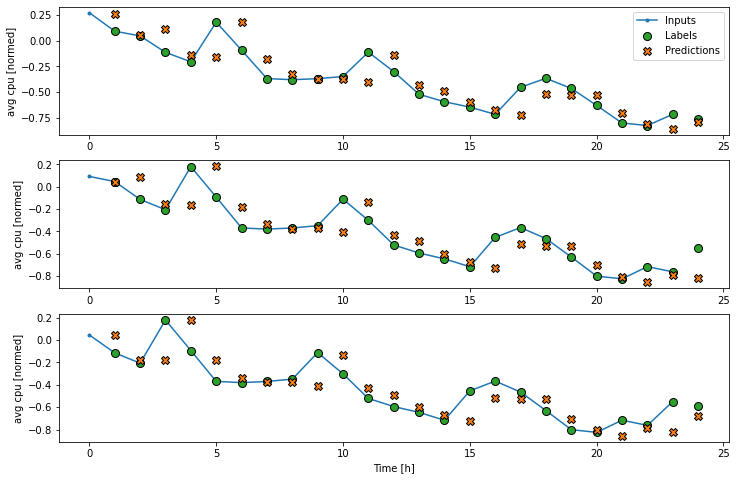

In [214]:
wide_window.plot(lstm_model)

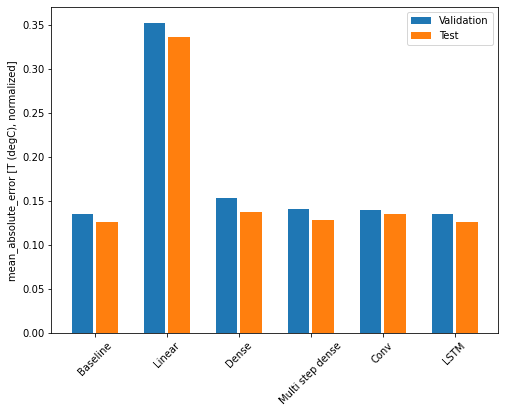

In [215]:
# let's talk performance
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [217]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1260
Linear      : 0.3364
Dense       : 0.1376
Multi step dense: 0.1279
Conv        : 0.1351
LSTM        : 0.1262
